<a href="https://colab.research.google.com/github/Thamindu17/time-series/blob/main/Forecasting_with_the_FB_Prophet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)


100%|██████████| 11.4M/11.4M [00:00<00:00, 72.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
!pip install prophet

In [4]:
# Run this cell first!
!pip install prophet -q

# Now import the library
from prophet import Prophet
import pandas as pd

print("✅ Prophet is successfully installed and ready to use.")

✅ Prophet is successfully installed and ready to use.


In [5]:
pjme = pd.read_csv('/root/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJME_hourly.csv')
pjme = pjme.set_index('Datetime')
pjme.index = pd.to_datetime(pjme.index)


In [6]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


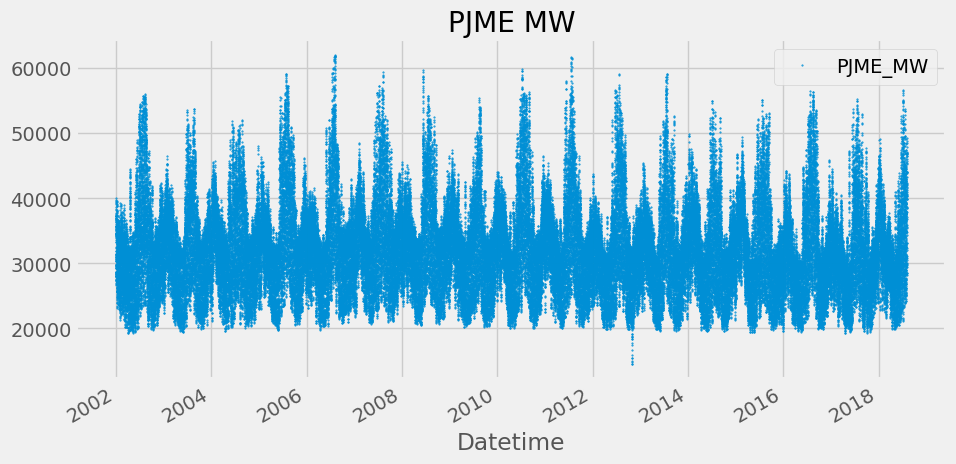

In [7]:
color_pal=sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()


# time series features

In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [9]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


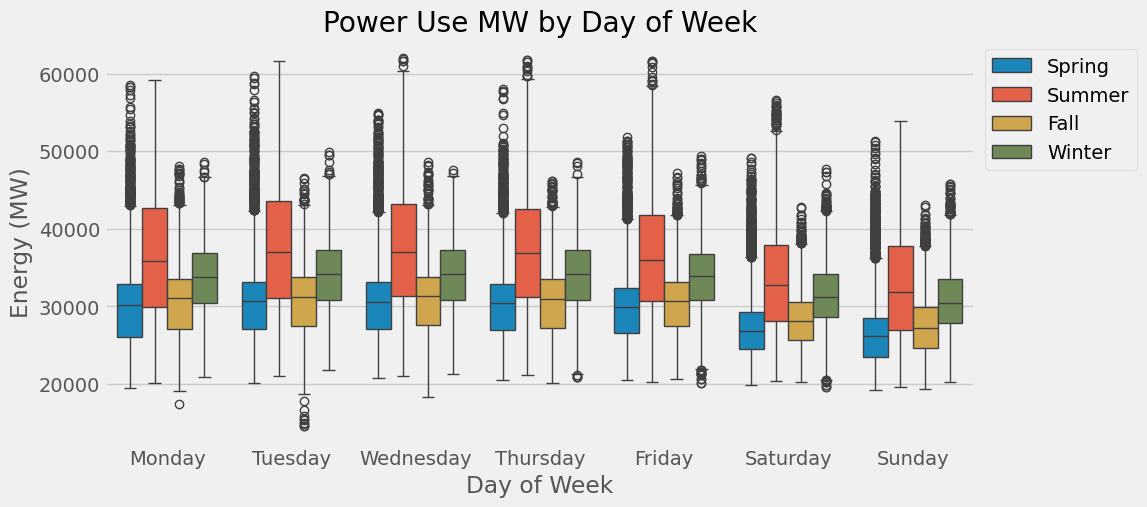

In [10]:
fig,ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target,
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train test split

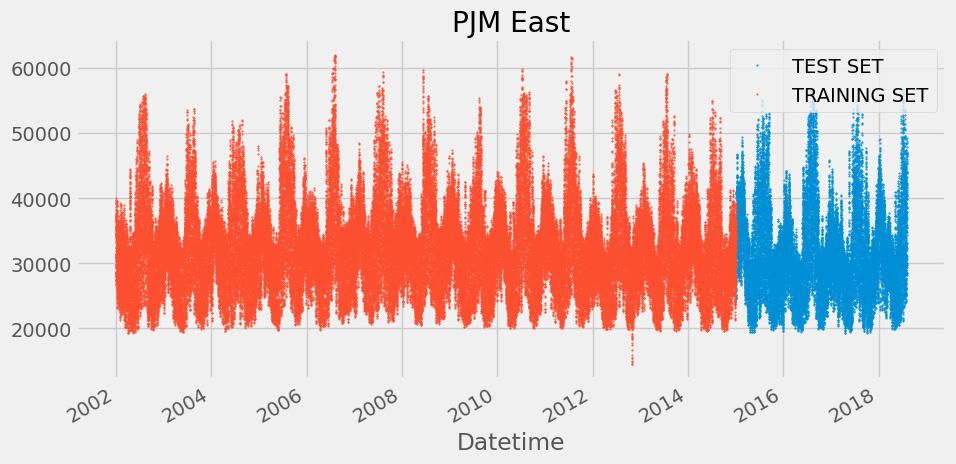

In [11]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

## Prophet Mode

In [12]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [13]:
pjme_train_prophet

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
113922,2014-01-01 20:00:00,36193.0
113923,2014-01-01 21:00:00,35601.0
113924,2014-01-01 22:00:00,34242.0
113925,2014-01-01 23:00:00,32215.0


In [14]:
%%time
model=Prophet()
model.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprt5llj8o/yrexhk_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprt5llj8o/v0t3i81i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20584', 'data', 'file=/tmp/tmprt5llj8o/yrexhk_k.json', 'init=/tmp/tmprt5llj8o/v0t3i81i.json', 'output', 'file=/tmp/tmprt5llj8o/prophet_modelw20bju01/prophet_model-20250921083338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 12.9 s, sys: 493 ms, total: 13.3 s
Wall time: 1min 49s


In [15]:
pjme_test_prophet =pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})


pjme_test_fcst =model.predict(pjme_test_prophet)

In [16]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23820.462412,32772.123225,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22218.960604,31603.298266,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21610.370215,30293.640138,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21059.813726,30351.911092,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,22183.151785,30615.504966,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


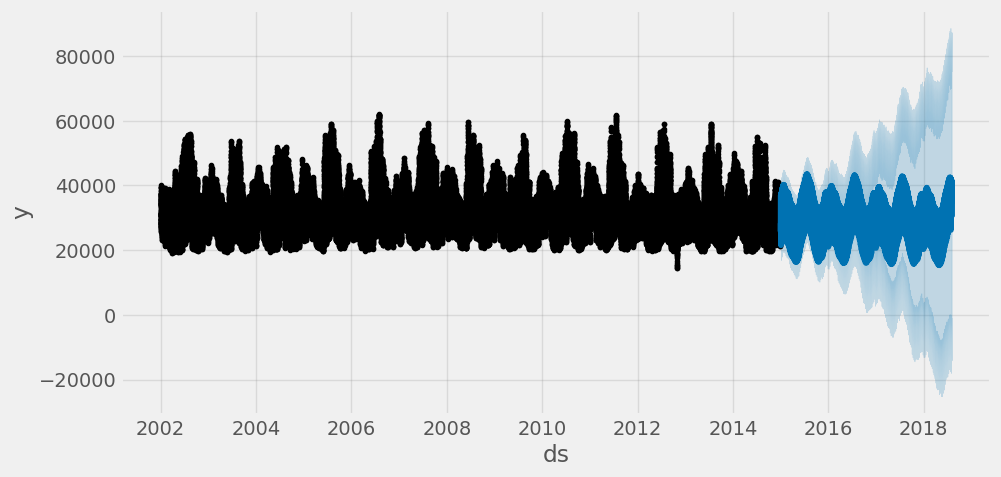

In [17]:
fig,ax=plt.subplots(figsize=(10,5))
fig=model.plot(pjme_test_fcst,ax=ax)
plt.show()

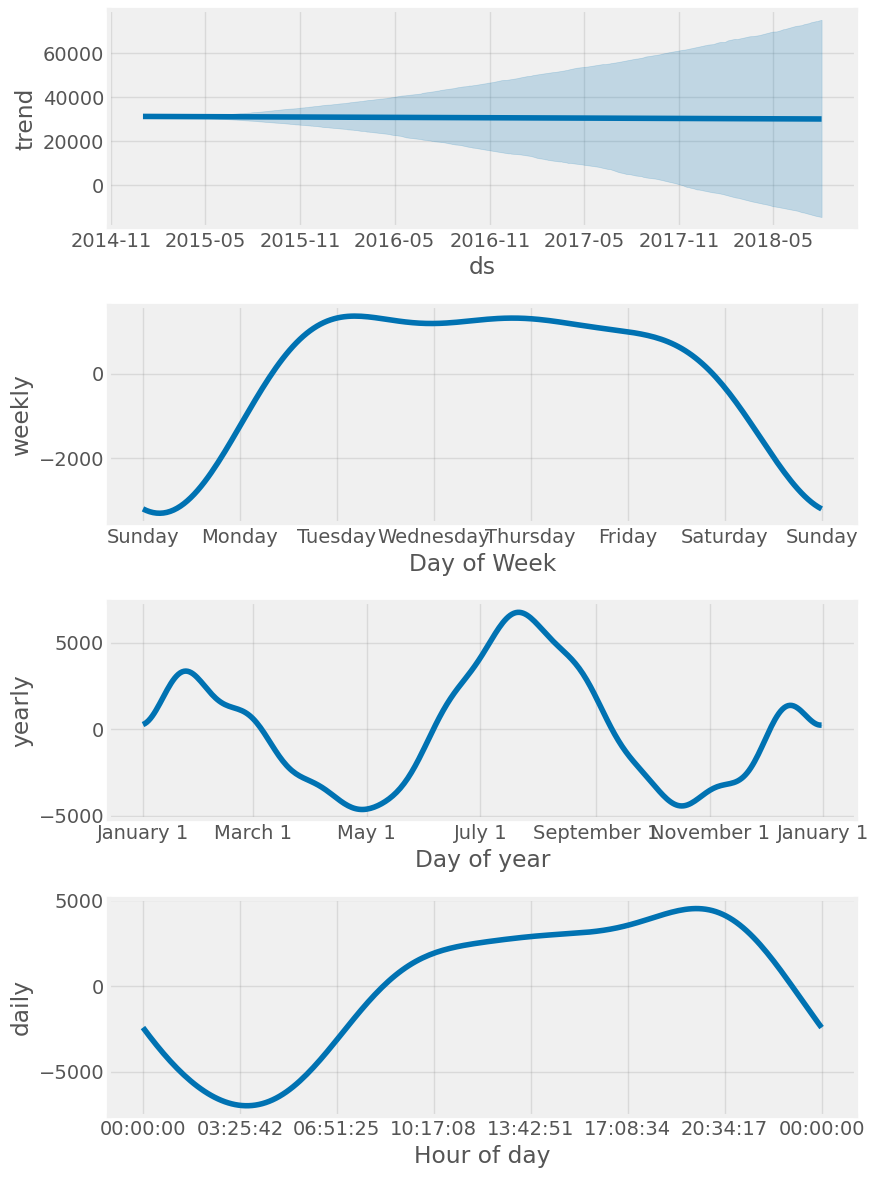

In [18]:
model.plot_components(pjme_test_fcst)
plt.show()

# compare forecast and actuals

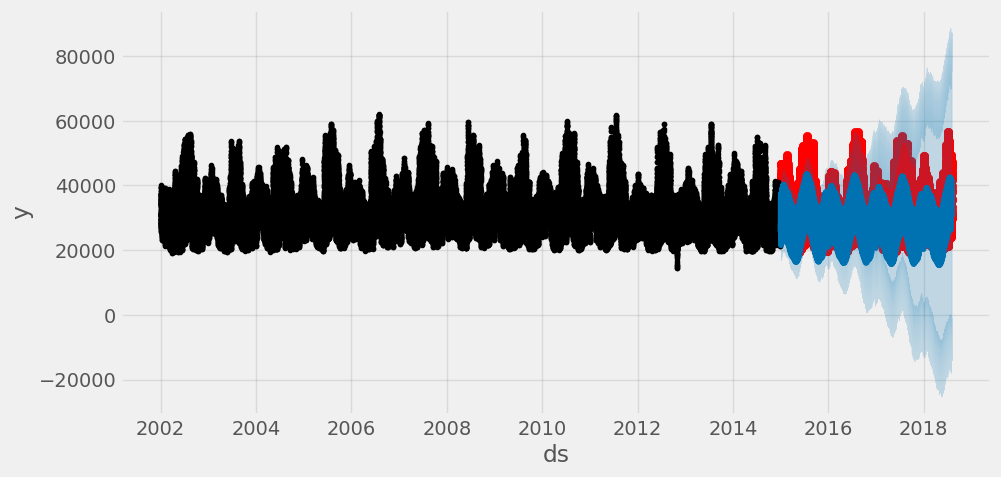

In [19]:
f,ax=plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index,pjme_test['PJME_MW'],color='r')
fig=model.plot(pjme_test_fcst,ax=ax)
plt.show()

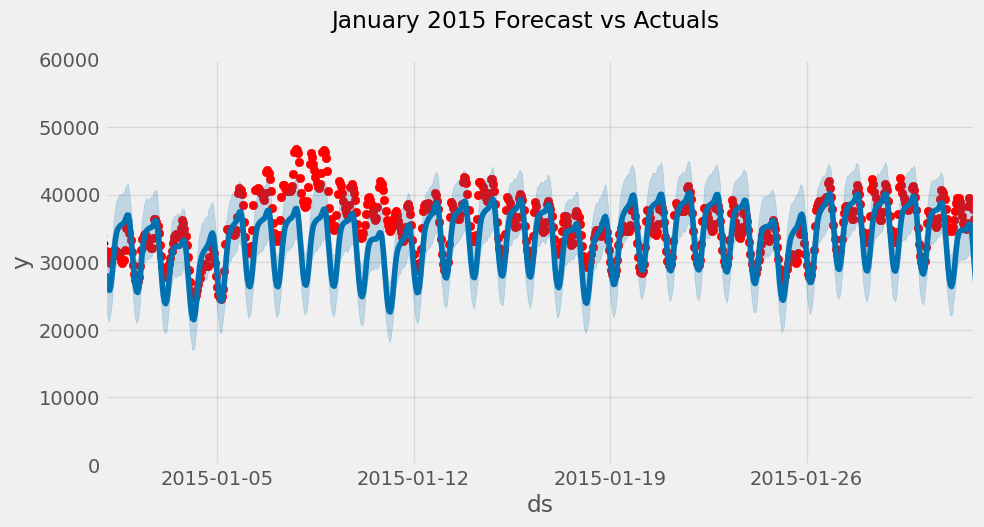

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'),
              upper=pd.to_datetime('02-01-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

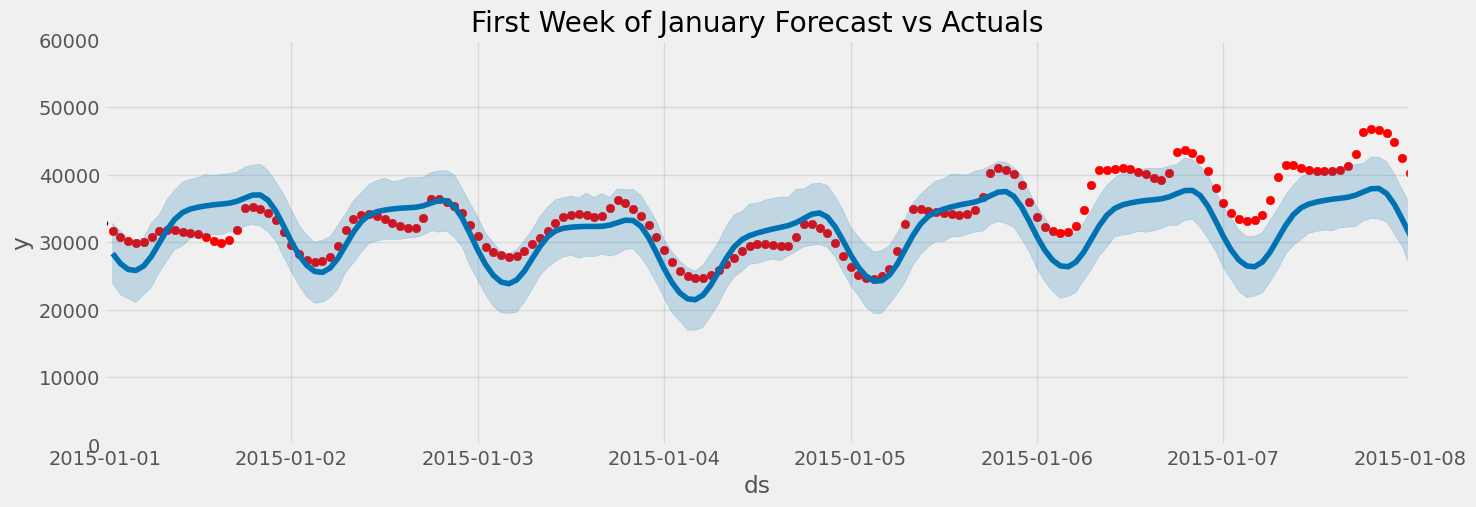

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'), upper=pd.to_datetime('01-08-2015'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

# evaluate

In [22]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

np.float64(6616.966074225221)

In [23]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.911537928106

In [24]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

np.float64(16.512003880182647)

# add holidays

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [26]:
holidays

DatetimeIndex(['2002-01-21', '2002-02-18', '2002-05-27', '2002-07-04',
               '2002-09-02', '2002-10-14', '2002-11-11', '2002-11-28',
               '2002-12-25', '2003-01-01',
               ...
               '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23',
               '2017-12-25', '2018-01-01', '2018-01-15', '2018-02-19',
               '2018-05-28', '2018-07-04'],
              dtype='datetime64[ns]', length=164, freq=None)

In [33]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprt5llj8o/5d14e132.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprt5llj8o/1p4xaksv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59450', 'data', 'file=/tmp/tmprt5llj8o/5d14e132.json', 'init=/tmp/tmprt5llj8o/1p4xaksv.json', 'output', 'file=/tmp/tmprt5llj8o/prophet_modelqs5tm6af/prophet_model-20250921083937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 11.5 s, sys: 394 ms, total: 11.9 s
Wall time: 2min 52s


In [35]:
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

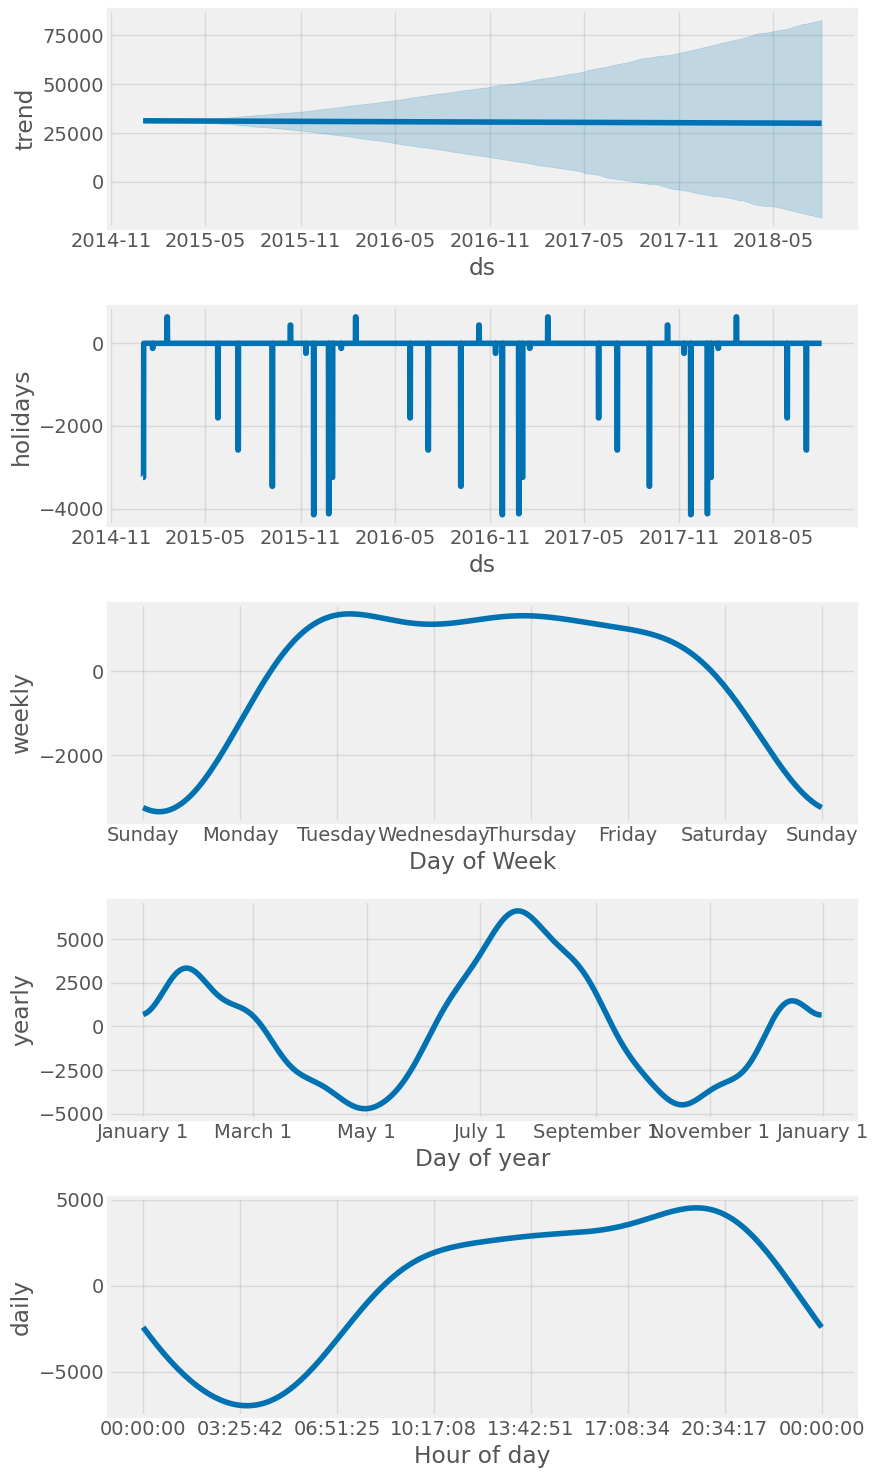

In [36]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

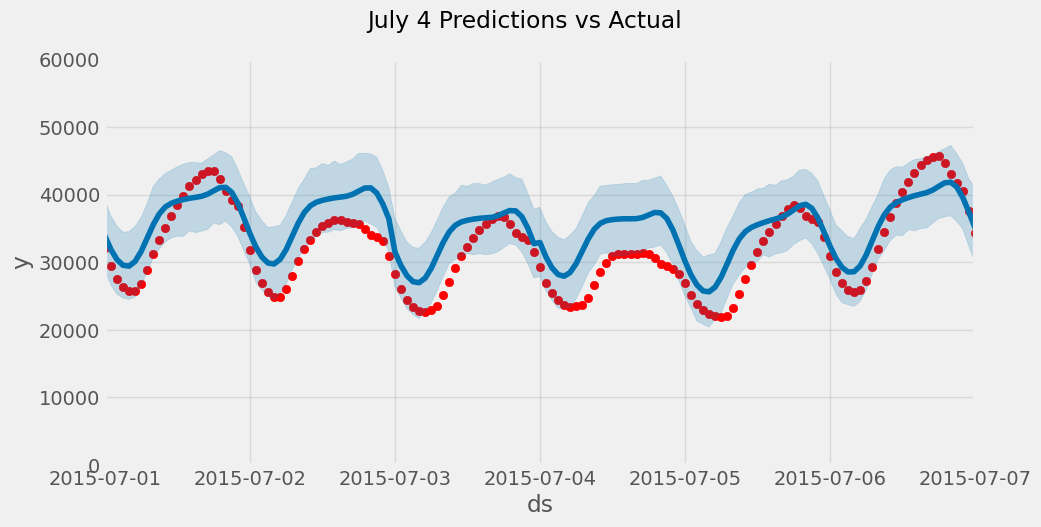

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower=pd.to_datetime('07-01-2015'),
              upper=pd.to_datetime('07-07-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [39]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [40]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25567.271675
1,2015-01-01 02:00:00,24065.351481
2,2015-01-01 03:00:00,23195.828972
3,2015-01-01 04:00:00,23056.212620
4,2015-01-01 05:00:00,23732.192245
